Install dependencies

In [2]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

Import your librarys

In [3]:
import time
import keras_cv
import keras
import matplotlib.pyplot as plt

Create stable diffusion model

In [ ]:
model = keras_cv.models.StableDiffusion(
    img_width=512, img_height=512, jit_compile=False
)

Add text to image prompt

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


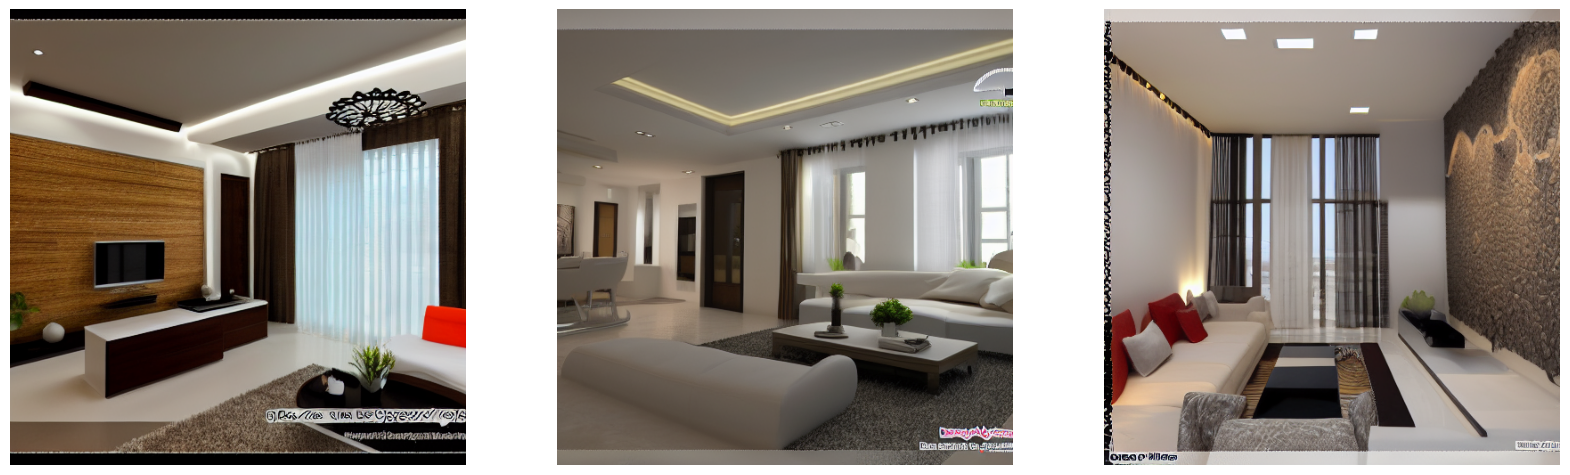

In [7]:
images = model.text_to_image("Interior house design", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

let's benchmark our unoptimized model

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
Standard model: 86.00 seconds


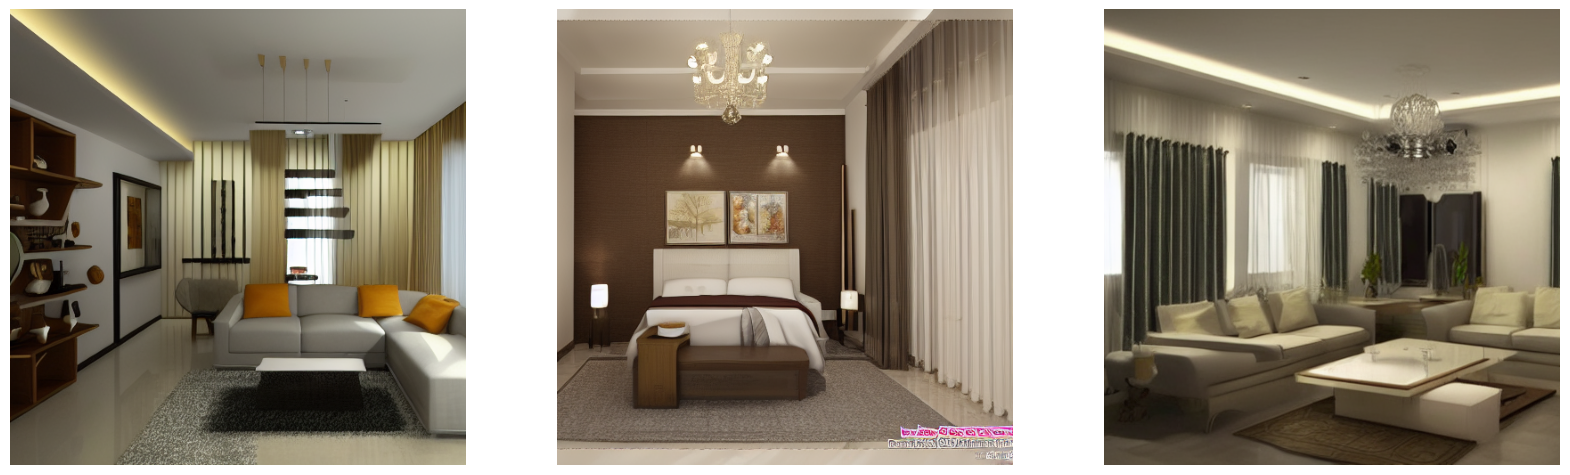

In [8]:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "Interior design of a house with different rooms",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standard model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # Clear session to preserve memory.

Lets Enable mixed precision computation in Keras using a simple call

In [9]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
model = keras_cv.models.StableDiffusion(jit_compile=False)

print("Compute dtype:", model.diffusion_model.compute_dtype)
print(
    "Variable dtype:",
    model.diffusion_model.variable_dtype,
)

 Warm up model to run graph tracing before benchmarking

50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 572ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 602ms/step
Mixed precision model: 30.79 seconds


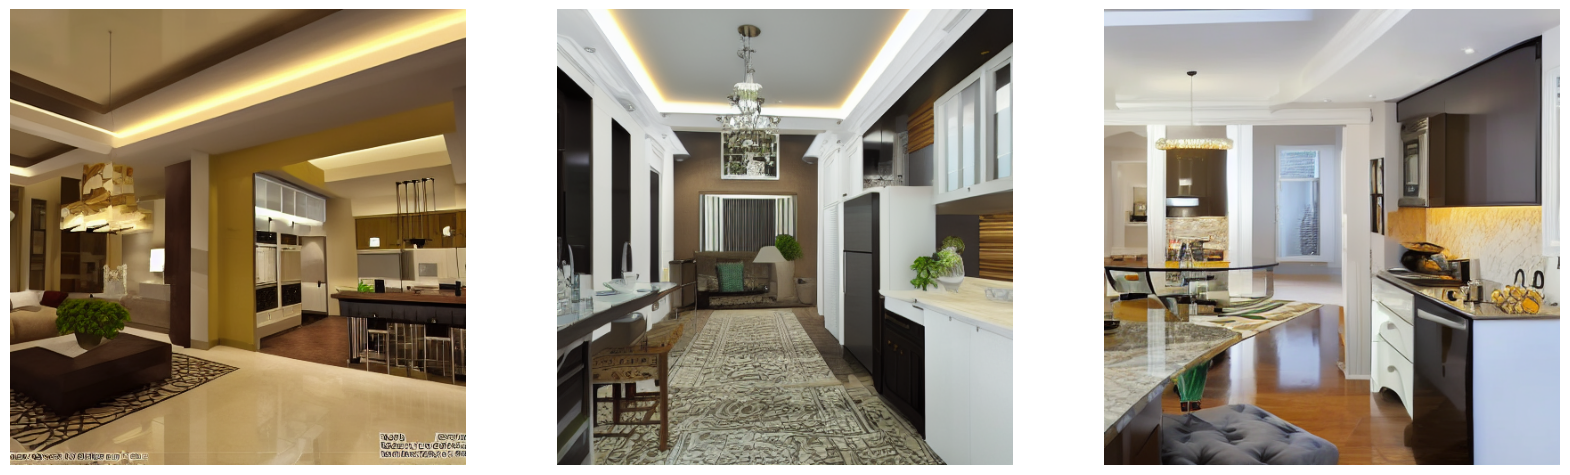

In [11]:
# Warm up model to run graph tracing before benchmarking.
model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "Interior design with kitchen, rooms, and lobby",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Mixed Precision", end - start])
plot_images(images)

print(f"Mixed precision model: {(end - start):.2f} seconds")
keras.backend.clear_session()

Lets set back to default for benchmarking purposes

In [ ]:
# Set back to the default for benchmarking purposes.
keras.mixed_precision.set_global_policy("float32")

model = keras_cv.models.StableDiffusion(jit_compile=True)
# Before we benchmark the model, we run inference once to make sure the TensorFlow
# graph has already been traced.
images = model.text_to_image("Interior design with sitting room, dinning, kitchen and lobby", batch_size=3)
plot_images(images)

Let's benchmark our XLA model:

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
With XLA: 85.71 seconds


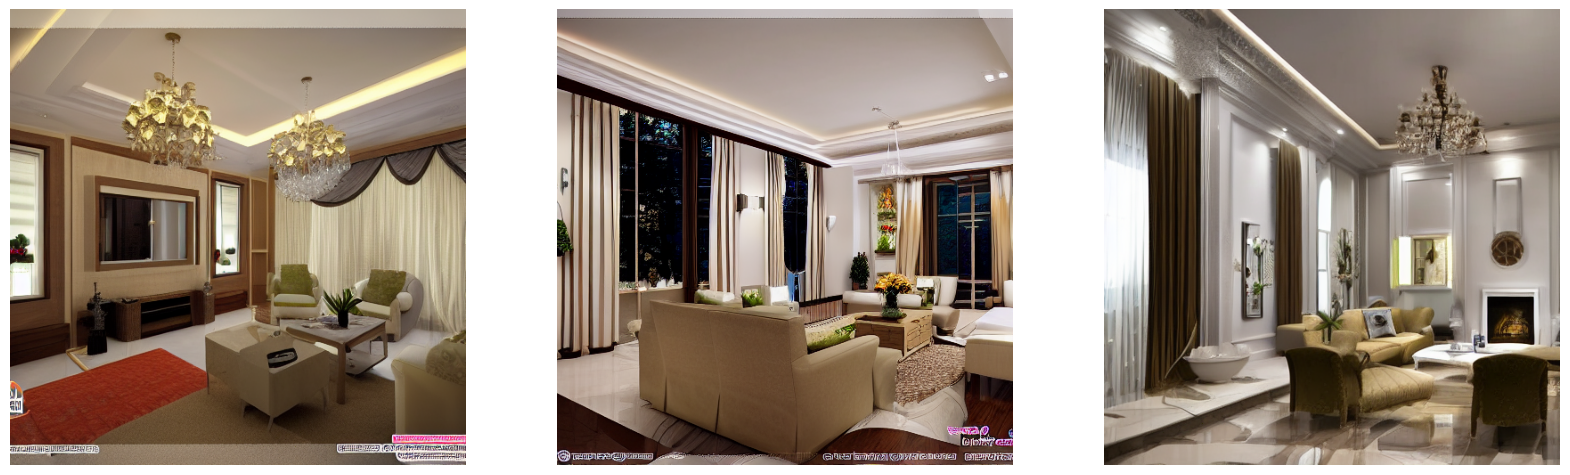

In [13]:
start = time.time()
images = model.text_to_image(
    "Interior design with sitting room, dinning, kitchen, bed rooms, and lobby",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA", end - start])
plot_images(images)

print(f"With XLA: {(end - start):.2f} seconds")
keras.backend.clear_session()

So lets assemble the stable diffusion inference pipeline With these two lines of code:

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

Let's check out the results:

In [19]:
print("{:<22} {:<22}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<22} {:<22}".format(name, runtime))

Model                  Runtime               
Standard               86.00133180618286     
Mixed Precision        30.78936457633972     
XLA                    85.71424221992493     
